
# WHO Decision Support Simulator - Simplified Dengue Model

This notebook mirrors some of the core functions of the World Health Organization Decision Support Simulator model for Dengue virus.

It runs a compact SEIR vector-borne model with temperature dependent biting and an optional intervention window.

For demonstration purposes, the following functions have been removed or reduced: serotype dynamics, no stochasticity (beyond initial conditions), simplified vector birth/death processes, very simple cosine seasonal temperature and Gaussian biting curve.

**How to use:**  
1. Run the cells top-to-bottom.  
2. Adjust parameters in the "Parameters" cell.  
3. Re-run the "Run simulation" cell to see updated results.


In [1]:
!pip install numpy matplotlib

from dataclasses import dataclass
from datetime import datetime, timedelta
import numpy as onp
import matplotlib.pyplot as plt

# Ensure plots render inline
%matplotlib inline


In [2]:

def seasonal_temperature(tmax: float, tmin: float, tmean: float, day_of_year: int, hemisphere: str = "South") -> float:
    """Cosine seasonality to approximate daily temperature with hemisphere phase shift."""
    hemi_flag = 0 if hemisphere.lower().startswith("n") else 1
    if hemi_flag == 0:
        temp = ((tmax - tmin) / 2.0) * onp.cos((2 * onp.pi / 365.0) * (day_of_year + 365.0 / 2.0)) + tmean
    else:
        temp = ((tmax - tmin) / 2.0) * onp.cos((2 * onp.pi / 365.0) * day_of_year) + tmean
    return float(onp.clip(temp, tmin, tmax))


def biting_rate_from_temp(temp_c: float) -> float:
    """Map temperature to biting multiplier (peaks near ~29C)."""
    T0 = 29.0
    k = 0.02
    return float(onp.exp(-k * (temp_c - T0) ** 2))


In [3]:

@dataclass
class Params:
    population: int = 100_000
    beta_hv_base: float = 0.30   # human <- vector
    beta_vh_base: float = 0.30   # vector <- human
    sigma_h: float = 1/5.0       # human incubation
    gamma_h: float = 1/5.0       # human recovery
    sigma_v: float = 1/8.0       # vector incubation
    mu_v: float = 1/14.0         # vector mortality
    Nv_per_human: float = 1.5
    dt: float = 1.0
    hemisphere: str = "South"
    tmin: float = 20.0
    tmax: float = 34.0
    tmean: float = 27.0
    intervention_start: datetime | None = None
    intervention_end: datetime | None = None
    intervention_effect: float = 0.0  # 0.4 => 40% reduction


@dataclass
class State:
    S: float
    E: float
    I: float
    R: float
    Sv: float
    Ev: float
    Iv: float


def step(state: State, t: int, start_date: datetime, p: Params) -> State:
    day_of_year = int((start_date + timedelta(days=t)).strftime("%j"))
    temp_c = seasonal_temperature(p.tmax, p.tmin, p.tmean, day_of_year, p.hemisphere)

    # Temperature-adjusted biting multiplier
    temp_mult = biting_rate_from_temp(temp_c)

    # Intervention window
    in_intervention = False
    if p.intervention_start and p.intervention_end:
        now = start_date + timedelta(days=t)
        in_intervention = (now >= p.intervention_start) and (now <= p.intervention_end)

    bite_reduction = (1.0 - p.intervention_effect) if in_intervention else 1.0

    # Effective transmission
    beta_hv = p.beta_hv_base * temp_mult * bite_reduction
    beta_vh = p.beta_vh_base * temp_mult * bite_reduction

    N_h = state.S + state.E + state.I + state.R
    N_v = state.Sv + state.Ev + state.Iv
    if N_v <= 0:
        N_v = 1.0

    # Human flows
    lambda_h = beta_hv * (state.Iv / N_v)
    dS = -lambda_h * state.S
    dE = lambda_h * state.S - p.sigma_h * state.E
    dI = p.sigma_h * state.E - p.gamma_h * state.I
    dR = p.gamma_h * state.I

    # Vector flows — stabilize around Nv_per_human * N_h
    Nv_target = p.Nv_per_human * N_h
    births_v = max(0.0, Nv_target - N_v) * p.mu_v
    lambda_v = beta_vh * (state.I / N_h if N_h > 0 else 0)
    dSv = births_v - lambda_v * state.Sv - p.mu_v * state.Sv
    dEv = lambda_v * state.Sv - p.sigma_v * state.Ev - p.mu_v * state.Ev
    dIv = p.sigma_v * state.Ev - p.mu_v * state.Iv

    return State(
        S=max(0.0, state.S + p.dt * dS),
        E=max(0.0, state.E + p.dt * dE),
        I=max(0.0, state.I + p.dt * dI),
        R=max(0.0, state.R + p.dt * dR),
        Sv=max(0.0, state.Sv + p.dt * dSv),
        Ev=max(0.0, state.Ev + p.dt * dEv),
        Iv=max(0.0, state.Iv + p.dt * dIv),
    )


def run_sim(days: int, seed: int, start_date: datetime, p: Params) -> dict:
    onp.random.seed(seed)

    # Initial conditions
    I0, E0, R0 = 10.0, 20.0, 0.0
    S0 = p.population - (I0 + E0 + R0)
    Nv0 = p.Nv_per_human * p.population
    Iv0, Ev0 = 30.0, 60.0
    Sv0 = Nv0 - (Iv0 + Ev0)

    state = State(S=S0, E=E0, I=I0, R=R0, Sv=Sv0, Ev=Ev0, Iv=Iv0)

    series = {
        "S": onp.zeros(days),
        "E": onp.zeros(days),
        "I": onp.zeros(days),
        "R": onp.zeros(days),
        "Sv": onp.zeros(days),
        "Ev": onp.zeros(days),
        "Iv": onp.zeros(days),
        "tempC": onp.zeros(days),
    }

    for t in range(days):
        series["S"][t] = state.S
        series["E"][t] = state.E
        series["I"][t] = state.I
        series["R"][t] = state.R
        series["Sv"][t] = state.Sv
        series["Ev"][t] = state.Ev
        series["Iv"][t] = state.Iv
        doy = int((start_date + timedelta(days=t)).strftime("%j"))
        series["tempC"][t] = seasonal_temperature(p.tmax, p.tmin, p.tmean, doy, p.hemisphere)

        state = step(state, t, start_date, p)

    return series


## Parameters

In [4]:

# Core simulation settings
DAYS = 365
SEED = 1
START_DATE = datetime(2025, 1, 1)

# Transmission baseline (applies to both directions for simplicity)
BETA = 0.30

# Temperature seasonality
HEMISPHERE = "South"
TMIN, TMAX, TMEAN = 20.0, 34.0, 27.0

# Population & vector ratio
POPULATION = 100_000
NV_PER_HUMAN = 1.5

# Optional intervention window (set to None to disable)
INTERVENTION_START = datetime(2025, 3, 1)
INTERVENTION_END   = datetime(2025, 6, 1)
INTERVENTION_EFFECT = 0.4  # 40% reduction in effective biting


## Run simulation

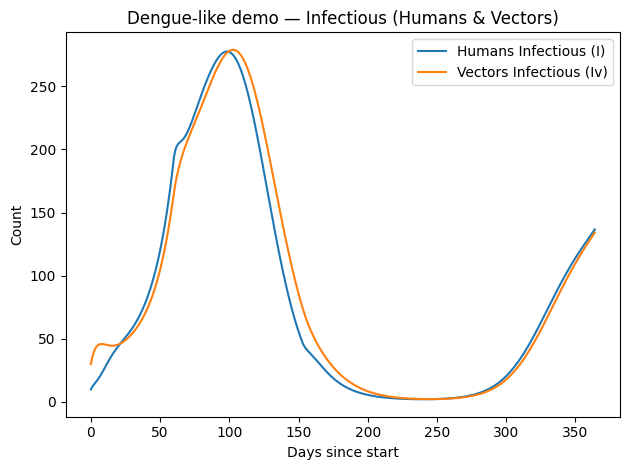

=== Demo Summary ===
Days simulated: 365
Peak human infections (I): 278 on day 98
Peak vector infections (Iv): 279 on day 103


In [5]:

p = Params(
    population=POPULATION,
    beta_hv_base=BETA,
    beta_vh_base=BETA,
    hemisphere=HEMISPHERE,
    tmin=TMIN, tmax=TMAX, tmean=TMEAN,
    intervention_start=INTERVENTION_START,
    intervention_end=INTERVENTION_END,
    intervention_effect=INTERVENTION_EFFECT,
    Nv_per_human=NV_PER_HUMAN,
)

series = run_sim(days=DAYS, seed=SEED, start_date=START_DATE, p=p)

# Plot infections (humans vs vectors)
plt.figure()
plt.plot(series["I"], label="Humans Infectious (I)")
plt.plot(series["Iv"], label="Vectors Infectious (Iv)")
plt.xlabel("Days since start")
plt.ylabel("Count")
plt.title("Dengue-like demo — Infectious (Humans & Vectors)")
plt.legend()
plt.tight_layout()
plt.show()

# Quick summary
peak_I = float(series["I"].max())
peak_day = int(series["I"].argmax())
peak_Iv = float(series["Iv"].max())
peak_day_v = int(series["Iv"].argmax())

print("=== Demo Summary ===")
print(f"Days simulated: {DAYS}")
print(f"Peak human infections (I): {peak_I:.0f} on day {peak_day}")
print(f"Peak vector infections (Iv): {peak_Iv:.0f} on day {peak_day_v}")


## Temperature seasonality (sanity check)

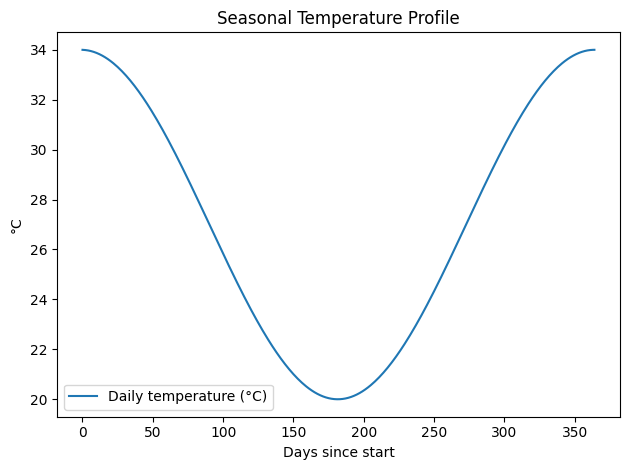

In [6]:

plt.figure()
plt.plot(series["tempC"], label="Daily temperature (°C)")
plt.xlabel("Days since start")
plt.ylabel("°C")
plt.title("Seasonal Temperature Profile")
plt.legend()
plt.tight_layout()
plt.show()
